<a href="https://colab.research.google.com/github/dfridland/PyTorch/blob/HW5/PyTorchHW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=e75f8fb93e2e437a7c758b6f06ceae5c9482db78e19e56485f74224f4e199d56
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=3cb93234f2d2d03640245188836103be1c9f2384c6460e6b5265736fa7847f60
  Stored in directory: /root/.cache/pip/w

In [3]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.nn import functional as F

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
! pip install -q kaggle

In [6]:
from google.colab import files


In [7]:
#  google.colab import drive
# drive.mount('/content/drfromive')

In [8]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dianafridlyand","key":"eb50b0058efb905468066fe811db57cd"}'}

In [9]:
! mkdir ~/.kaggle

In [10]:
! cp kaggle.json ~/.kaggle/

In [11]:
! chmod 600 ~/.kaggle/kaggle.json



In [12]:
!pwd

/content


In [13]:
! kaggle datasets list

ref                                                        title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                      Spotify and Youtube                              9MB  2023-03-20 15:43:25           5460        207  1.0              
erdemtaha/cancer-data                                      Cancer Data                                     49KB  2023-03-22 07:57:00           1371         35  1.0              
ulrikthygepedersen/fastfood-nutrition                      Fastfood Nutrition                              12KB  2023-03-21 10:02:41           1611         38  1.0              
lokeshparab/amazon-products-dataset                        Amazon Products Sales Dataset 2023              80M

In [14]:
!kaggle datasets download -d olekslu/makeup-lips-segmentation-28k-samples

100% 2.37G/2.38G [00:58<00:00, 54.4MB/s]
100% 2.38G/2.38G [00:58<00:00, 43.5MB/s]


In [ ]:
!unzip /content/makeup-lips-segmentation-28k-samples.zip -d Lipsdataset

In [16]:
IMG = 256
def resize_images(image_file, mask_file, new_size):

  image = cv2.imread(str(IMAGES_FILEPATH.joinpath(image_file)))
  mask = cv2.imread(str(MASKS_FILEPATH.joinpath(mask_file)))
  resize_img = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
  resize_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)

  return resize_img, resize_mask

class LipsDataset(torch.utils.data.Dataset):

    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing

        self.image_arr = self.data.iloc[:,0]
        self.label_arr = self.data.iloc[:,1]

        self.data_len = len(self.data.index)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):

        img_path =  self.image_arr[idx]
        mask_path = self.label_arr[idx]
        img, mask = resize_images(img_path, mask_path, IMG)
        img = img.astype(float)

        if self.preprocessing:
          img = self.preprocessing(img)
          img = torch.as_tensor(img)
        else:
          img = torch.as_tensor(img)
          img /= 255.0
        img = img.permute(2, 0, 1)

        mask_1 = mask[..., 1]
        mask_1 = np.where(mask > 50, 1, 0)[:, :, 1]
        mask_1 = mask_1.astype('float')
        masks = [mask_1]
        masks = torch.as_tensor(masks, dtype=torch.float)

        return img.float(), masks

    

In [17]:
DATASET_FILEPATH = Path('./content/Lipsdataset/set-lipstick-original')
IMAGES = '/content/Lipsdataset/set-lipstick-original/720p'
MASKS = '/content/Lipsdataset/set-lipstick-original/mask'
LIST_CSV = '/content/Lipsdataset/set-lipstick-original/list.csv'

IMAGES_FILEPATH = DATASET_FILEPATH.joinpath(IMAGES)
MASKS_FILEPATH = DATASET_FILEPATH.joinpath(MASKS)
LIST_CSV_FILEPATH = DATASET_FILEPATH.joinpath(LIST_CSV)

In [18]:
df_lips_images = pd.read_csv(LIST_CSV_FILEPATH)
df_lips_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [19]:
feats = ['filename', 'mask']

df_lips_images = df_lips_images[feats]
df_lips_images.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [20]:
list_images = sorted(set([i for i in Path(IMAGES_FILEPATH).iterdir()]))
list_masks = sorted(set([i for i in Path(MASKS_FILEPATH).iterdir()]))
len(list_images), len(list_masks)
     

(28594, 28540)

In [21]:
df_lips_images = df_lips_images.loc[df_lips_images['mask'].isin([i.name for i in list_masks])]
df_lips_images.reset_index(drop=True, inplace=True)
df_lips_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [22]:
BACKBONE = 'resnet34'
segmodel = smp.Linknet(encoder_name=BACKBONE, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 99.5MB/s]


In [23]:
X_train, X_valid = train_test_split(df_lips_images,test_size=0.3, random_state=42)

X_train.reset_index(drop=True,inplace=True)
X_valid.reset_index(drop=True,inplace=True)


train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

In [24]:
X = X_train.iloc[:,1]
X

0        mask00021224.png
1        mask00002499.png
2        mask00011587.png
3        mask00012988.png
4        mask00005503.png
               ...       
19973    mask00021630.png
19974    mask00005391.png
19975    mask00000861.png
19976    mask00015850.png
19977    mask00023709.png
Name: mask, Length: 19978, dtype: object

In [25]:
X_train.shape, X_valid.shape

((19978, 2), (8562, 2))

In [26]:
#Loaders

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=8, shuffle=False)
     

<ipython-input-16-d1bd1cf3103c>:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  masks = torch.as_tensor(masks, dtype=torch.float)


torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])
tensor(0.) tensor(1.)


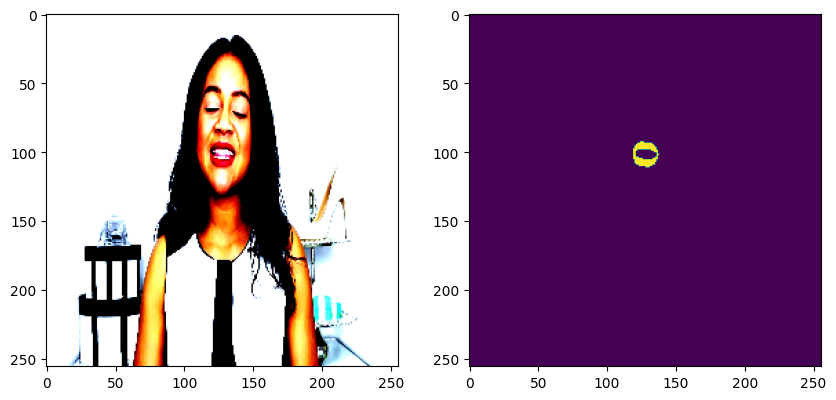

In [27]:
for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    im = np.squeeze(masks[0].permute(1, 2, 0))
    ax[1].imshow(im)
    break

In [28]:
criterion = smp.utils.losses.BCELoss()
metrics = [smp.utils.metrics.IoU(), ]
optimizer = optim.Adam(segmodel.parameters(), lr = 0.001)

In [29]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel,
    loss=criterion,
    metrics= metrics, 
    optimizer=optimizer,
    device=device, 
    verbose=True
)
valid_epoch = smp.utils.train.ValidEpoch(
    segmodel,
    loss=criterion,
    metrics= metrics, 
    
    device=device, 
    verbose=True
)


In [30]:
max_score = 0

for i in range(0,1):
  print(f'Epoch:{i + 1}')
  train_logs = train_epoch.run(train_loader)
  valid_logs = valid_epoch.run(valid_loader)

  if max_score < valid_logs['iou_score']:
    torch.save(segmodel, './best_model.pth')
    print("model saved")


Epoch:1
valid: 100%|██████████| 1071/1071 [04:56<00:00,  3.62it/s, bce_loss - 0.002131, iou_score - 0.9294]
model saved


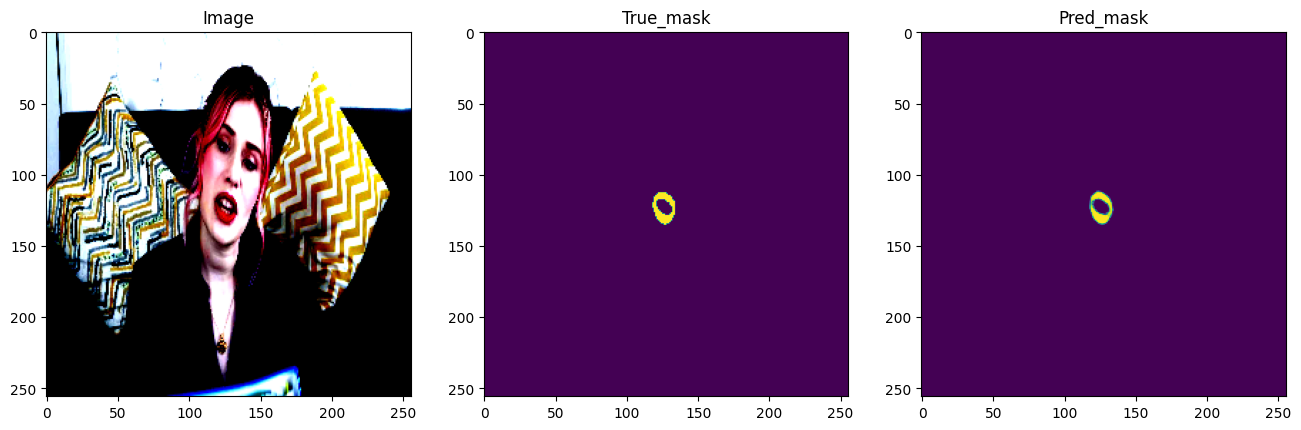

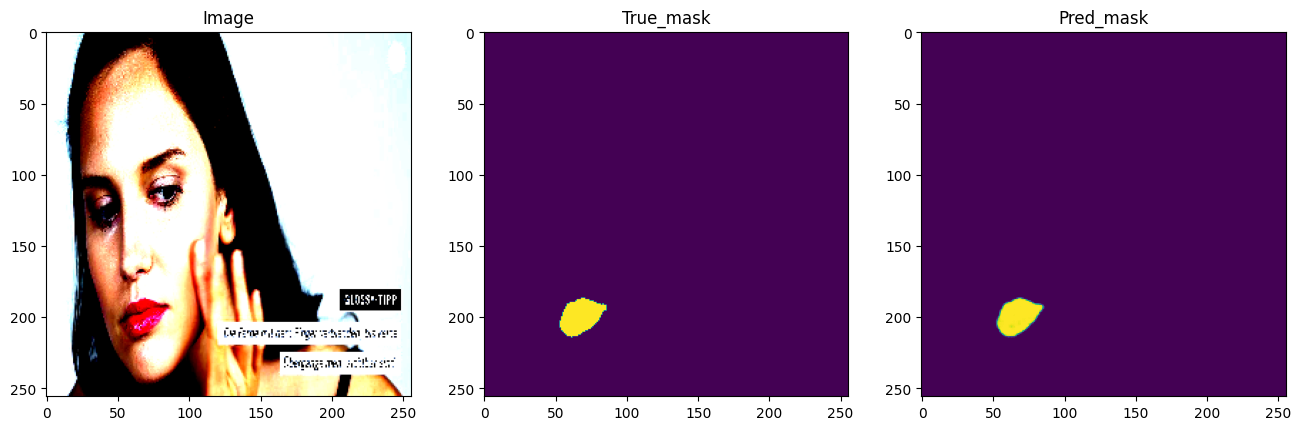

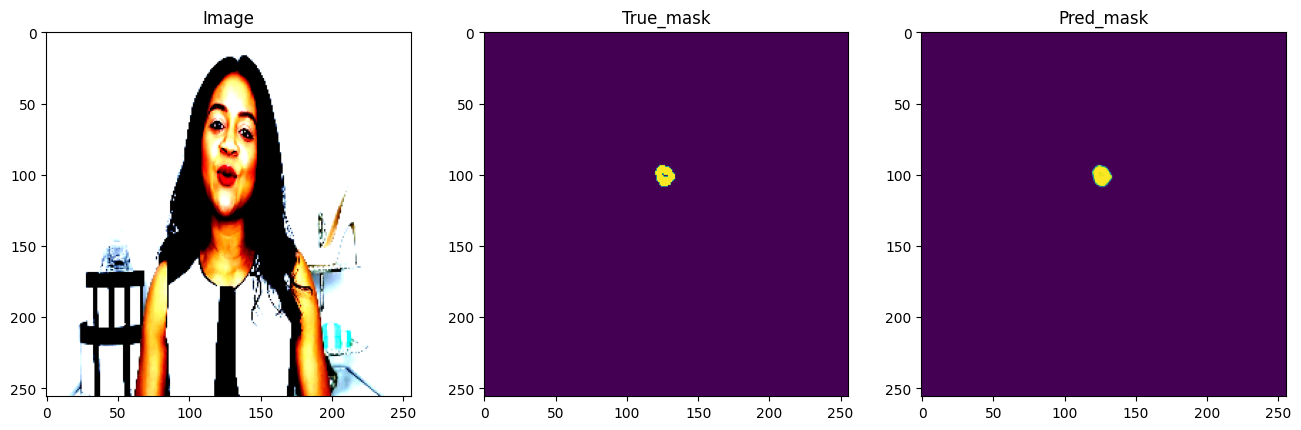

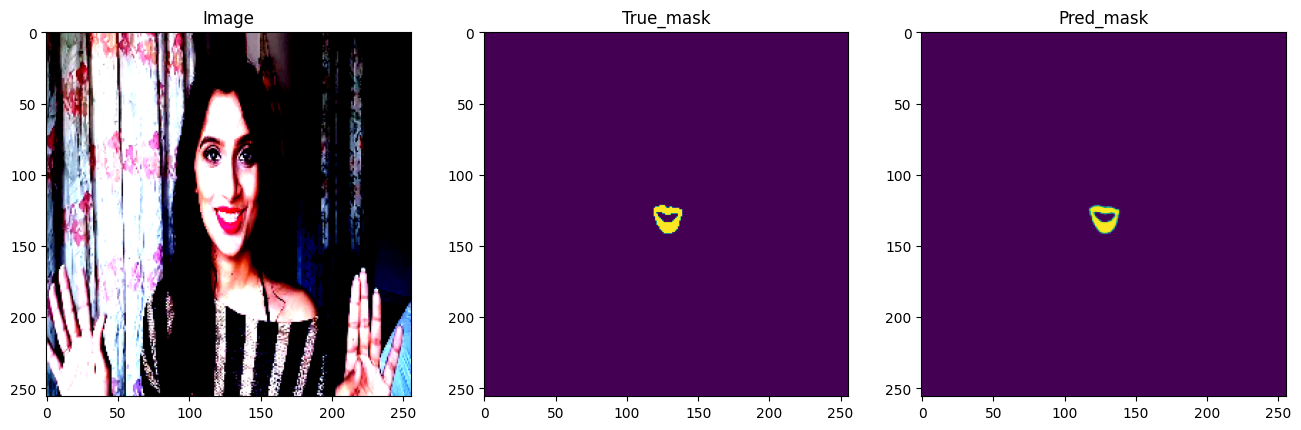

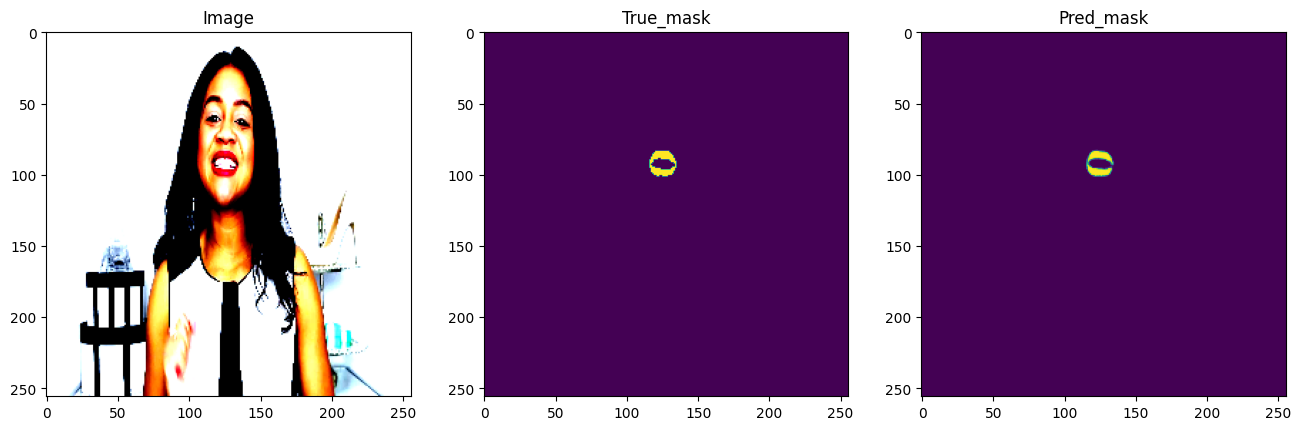

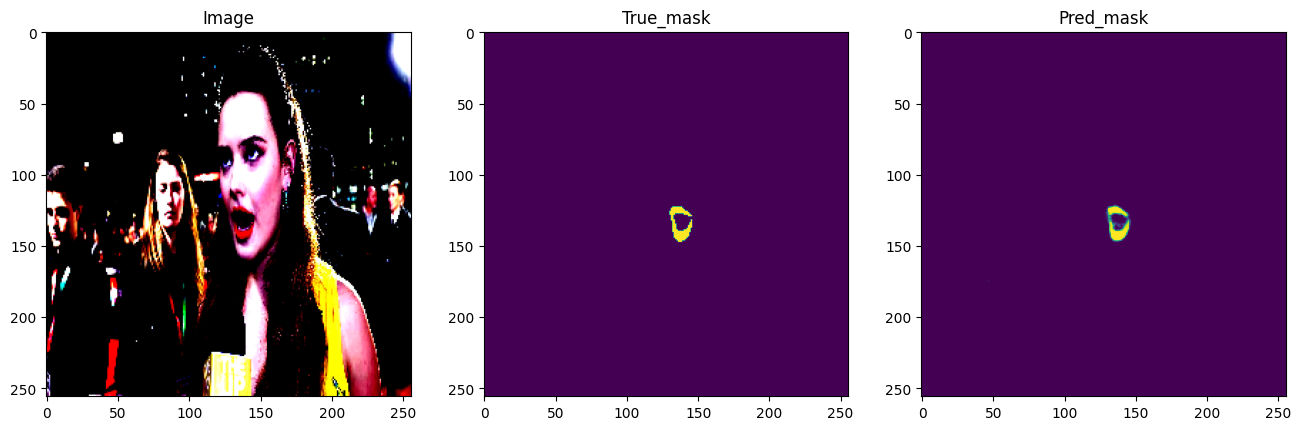

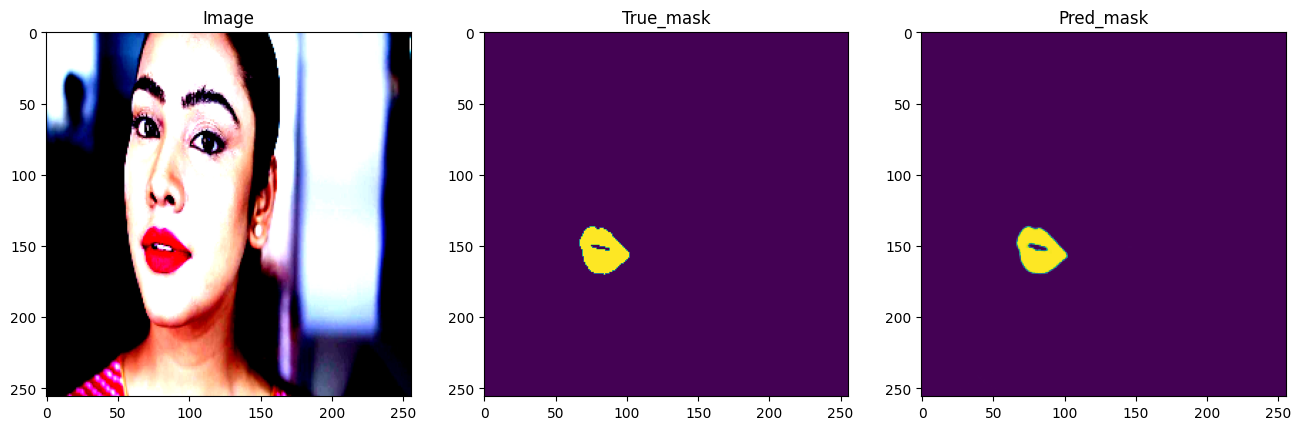

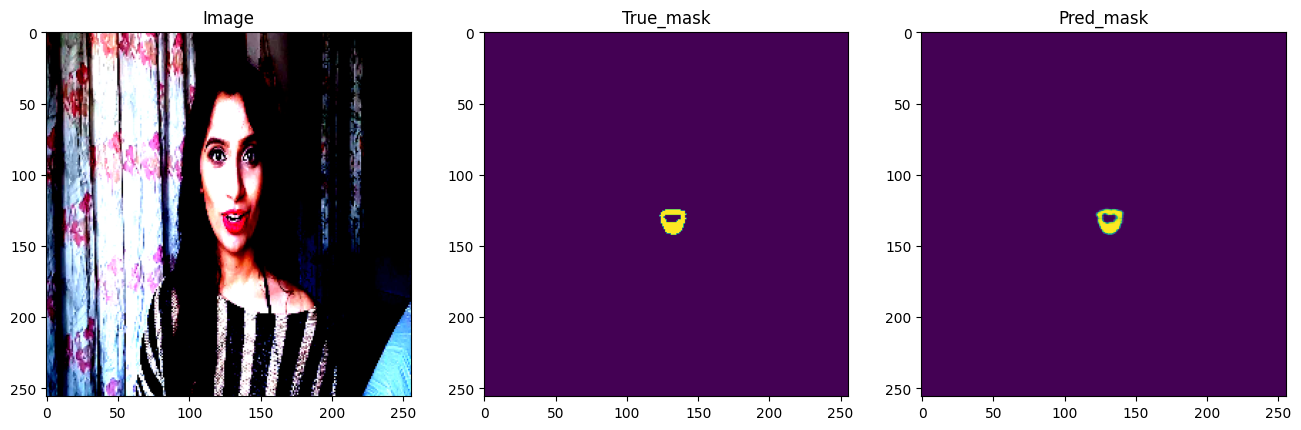

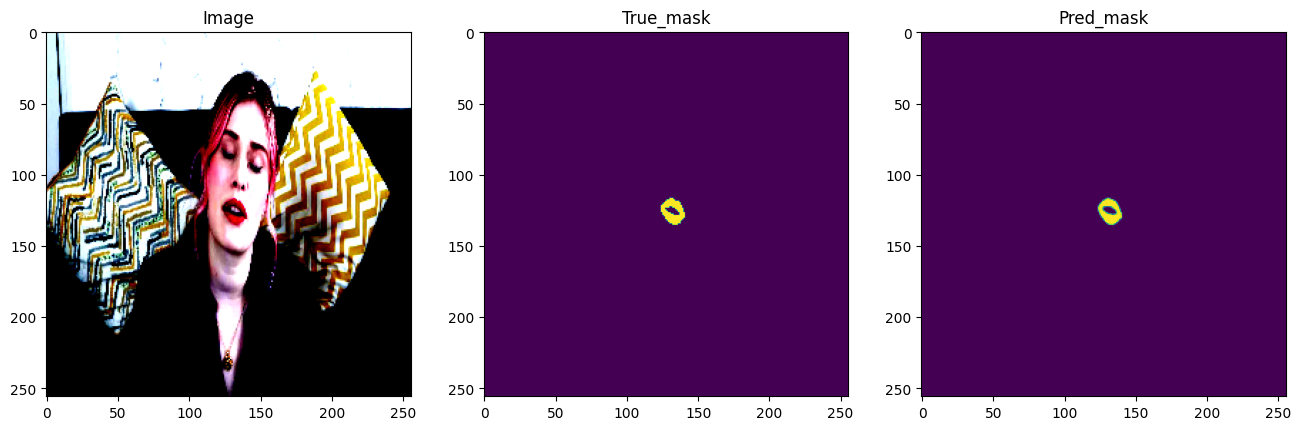

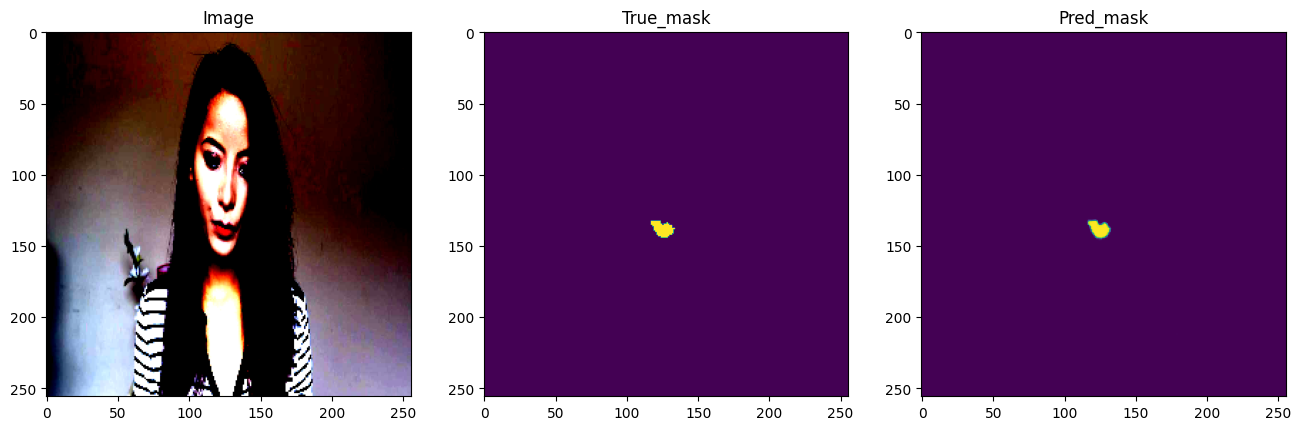

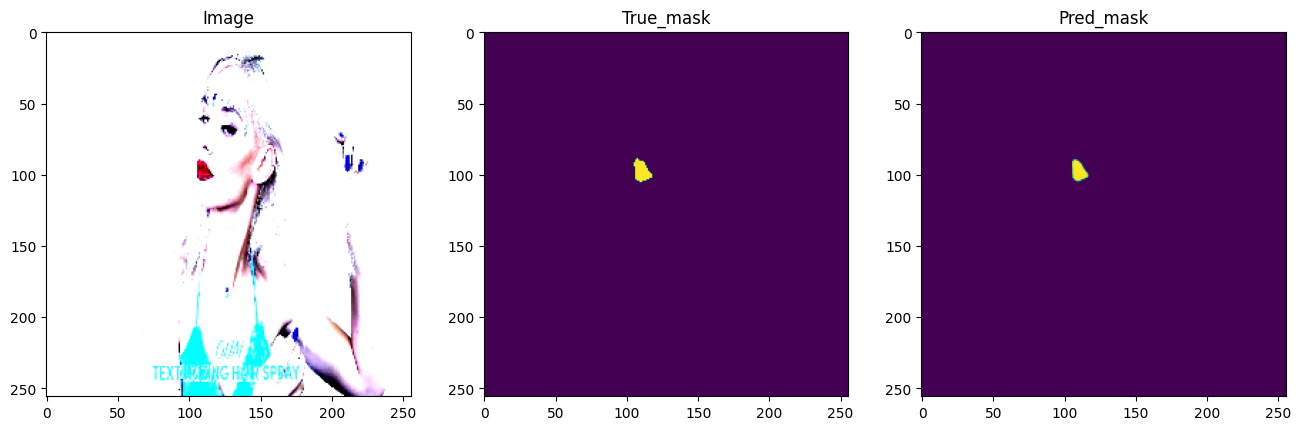

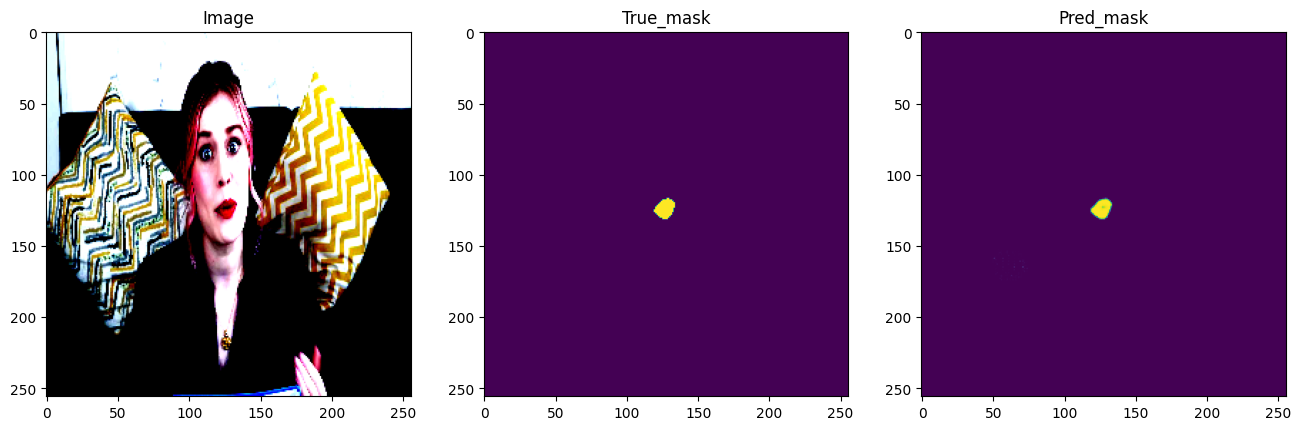

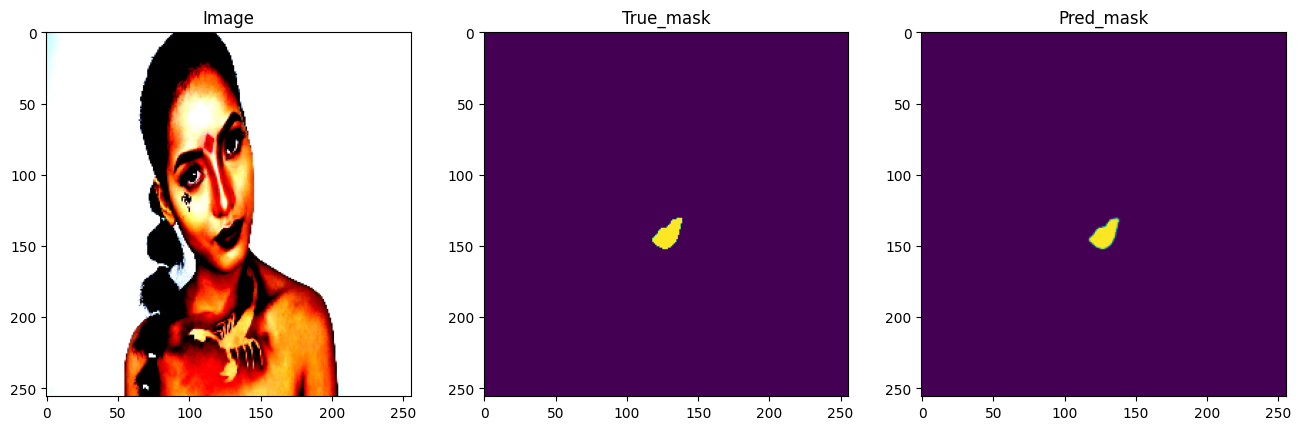

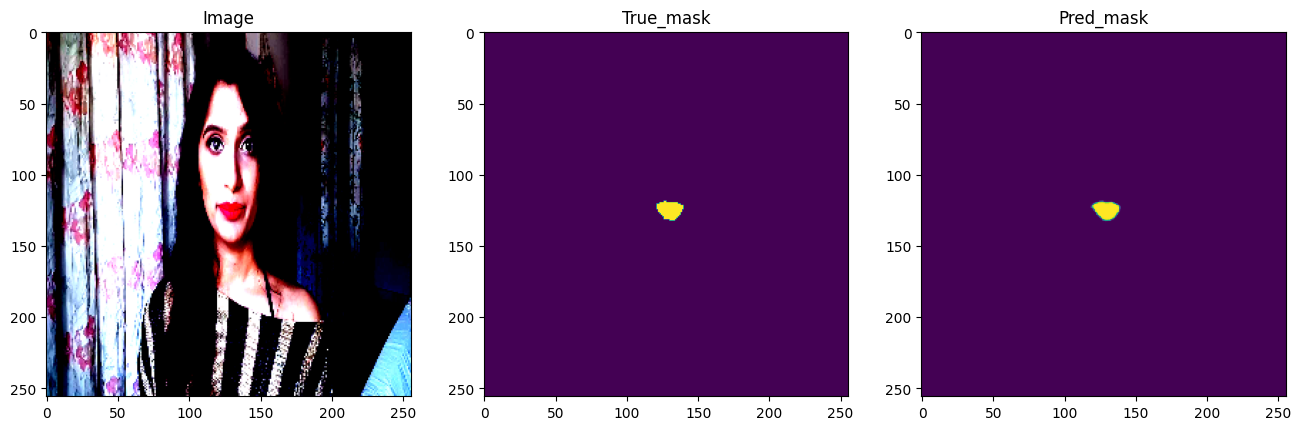

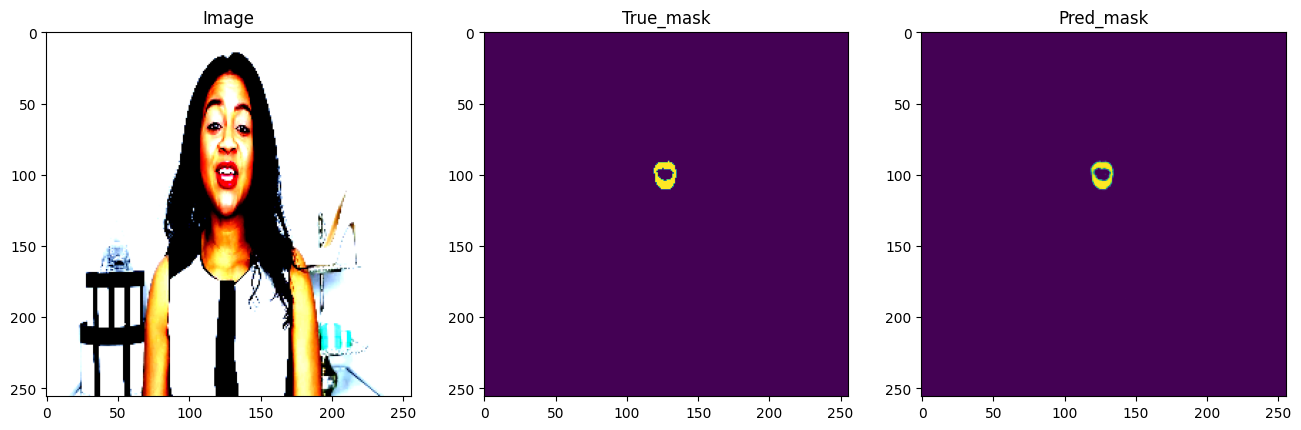

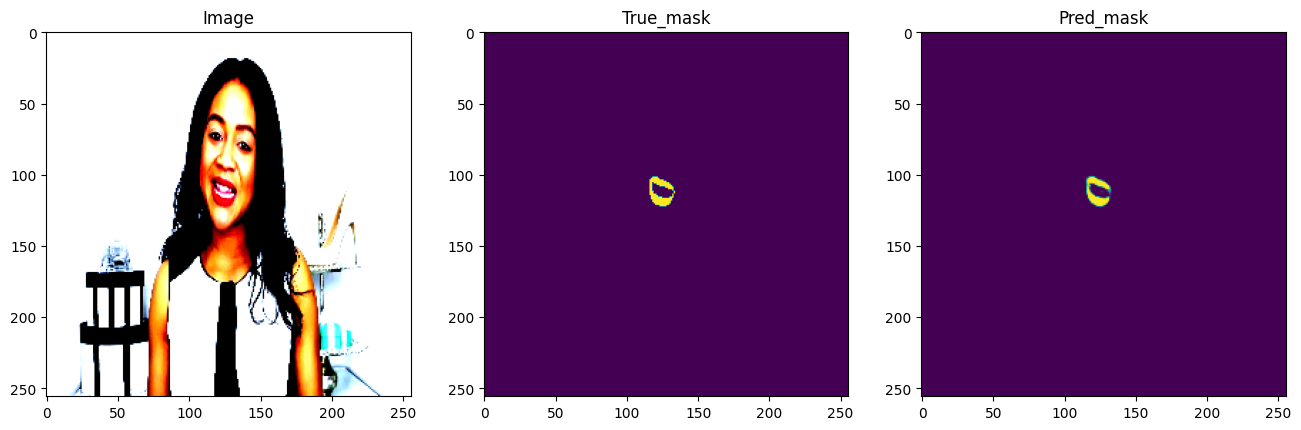

In [38]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')

    ax_2.imshow(np.squeeze(labels[i, ].cpu().permute(1, 2, 0)))
    ax_2.set_title('True_mask')
    
    ax_3.imshow(np.squeeze(outputs.detach().cpu()[i, ].permute(1, 2, 0)))
    ax_3.set_title('Pred_mask')